### ライブラリのImport

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import accuracy_score
from sklearn.cluster import SpectralClustering

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from timm.scheduler import CosineLRScheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models

from dsets import getOneDiceRotate90
from dsets import ImageDataset

from models import RegNetWrapper
from models import ResNet18Wrapper

2023-11-02 23:19:00.801361: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 23:19:00.801428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 23:19:00.801449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 23:19:00.815074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 23:19:02.098154: W tensorflow/compiler/

### 画像の前処理

In [2]:
imgs, labels = getOneDiceRotate90(data_type='trn')

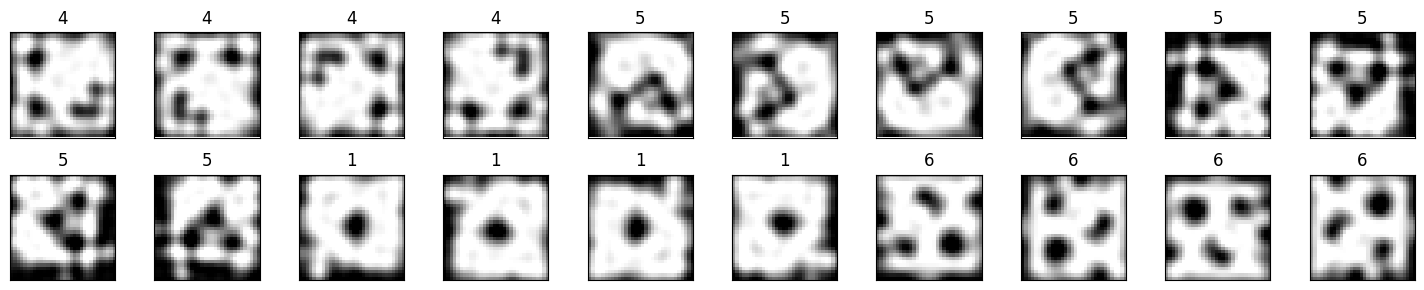

In [6]:
# 可視化
n = 20
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for i in range(n):
    ax = fig.add_subplot(n//10, 10, i+1)
    plt.imshow(imgs[i+10000], cmap='gray')
    plt.title(labels[i+10000])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

##### 訓練データ, 検証データの平均, 標準偏差の算出

In [2]:
from torchvision import transforms
from sklearn.model_selection import train_test_split

trn_imgs, val_imgs, trn_labels, val_labels = \
    train_test_split(imgs, labels, train_size=0.8, stratify=labels, random_state=1)

image_ToTensor = transforms.ToTensor()

# 訓練データの平均
import torch
trn_img_sum = 0
for trn_img in trn_imgs:
    img_t = image_ToTensor(trn_img)
    trn_img_sum += torch.sum(img_t[0])
# print(trn_img_sum)
trn_mean = trn_img_sum / (32*32*len(trn_imgs))
print(f'訓練データの平均: {trn_mean}')

# 訓練データの標準偏差
trn_img_s2 = 0
for trn_img in trn_imgs:
    img_t = image_ToTensor(trn_img)
    trn_img_s2 += torch.sum((img_t[0] - trn_mean)**2)
trn_std = torch.sqrt(trn_img_s2/(32*32*len(trn_imgs)))
print(f'訓練データの標準偏差: {trn_std}')   

# 検証データ
import torch
val_img_sum = 0
for val_img in val_imgs:
    img_t = image_ToTensor(val_img)
    val_img_sum += torch.sum(img_t[0])
# print(val_img_sum)
val_mean = val_img_sum / (32*32*len(val_imgs))
print(f'検証データの平均: {val_mean}')

# 訓練データの標準偏差
val_img_s2 = 0
for val_img in val_imgs:
    img_t = image_ToTensor(val_img)
    val_img_s2 += torch.sum((img_t[0] - trn_mean)**2)
val_std = torch.sqrt(val_img_s2/(32*32*len(val_imgs)))
print(f'検証データの標準偏差: {val_std}')

NameError: name 'imgs' is not defined

##### DataLoader作成

In [2]:
BATCH_SIZE = 128

In [3]:
train_ds = ImageDataset(data_type='trn')
valid_ds = ImageDataset(data_type='val')

In [4]:
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    drop_last=True
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### 学習

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
model = RegNetWrapper()
# model.load_state_dict(torch.load('/mnt/c/Users/user/MyData/SonyDice/models/regnet32_non_bin/E8_2023-11-02_20-45.pt'))
model.to(device)

RegNetWrapper(
  (regnet): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(232, 232, kernel_size=

In [7]:
log_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
writer = SummaryWriter(log_dir=f"./log/regnet32_non_bin_finetune_all_data_from_E8_{log_time}/")

In [8]:
torch.cuda.empty_cache()

In [9]:
EPOCH_NUM = 10
VAL_CADENSE = 1

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH_NUM, eta_min=1e-6)

scheduler = CosineLRScheduler(
    optimizer,
    t_initial=EPOCH_NUM,
    lr_min=1e-7,
    warmup_t=3,
    warmup_lr_init=1e-6,
    warmup_prefix=True
)

criterion = nn.CrossEntropyLoss()

In [10]:
#######################################################
# 保存先フォルダの設定を確認する!!
#######################################################

best_acc = -1
pbar = tqdm(range(EPOCH_NUM))

for epoch in pbar:
    # モデルを学習モードにする
    model.train()

    # 1epochで学習したデータの数
    train_data_num = 0

    # 正解した総数
    acc_num = 0

    # lossの保存リスト
    loss_epoch = []

    # バッチごとに処理する
    for iter_num, (X, y) in enumerate(train_dl):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        with torch.autocast("cuda"):
            y_logit, y_softmax = model(X)
            loss = criterion(y_logit, y)

        loss.backward()
        optimizer.step()

        # lossを記録
        loss_batch = loss.to('cpu').detach().numpy().copy()
        loss_epoch.append(loss_batch)

        # softmaxによる確率で目を決定
        _, max_idx = torch.max(y_softmax, dim=1)
        max_idx_c = max_idx.to('cpu').detach().numpy().copy()
        y_c = y.to('cpu').detach().numpy().copy()

        # ラベルと合致する予測の数を数えてacc_numに加算する
        acc_num += accuracy_score(max_idx_c, y_c, normalize=False)

        # 処理したデータの数を加算
        train_data_num += len(max_idx_c)
        
        pbar.set_description(f"Epoch/Iter {epoch}/{iter_num}")

    loss_mean = sum(loss_epoch)/len(loss_epoch)
    acc = acc_num / train_data_num

    writer.add_scalar("train/loss", loss.item(), epoch)
    writer.add_scalar("train/acc", acc, epoch)
    # writer.add_scalar('learning rate', optimizer.param_groups[0]['lr'], epoch)

    print(f"trn loss: {loss_mean:.4f}, trn acc: {acc:.4f}, lr: {optimizer.param_groups[0]['lr']:.7f}")
    # print(f"trn loss: {loss_mean:.4f}, trn acc: {acc:.4f}")
    scheduler.step(epoch)

    # validation
    if epoch == 0 or epoch % VAL_CADENSE == 0 or epoch == EPOCH_NUM-1:
        # 検証モードにする
        model.eval()

        # 検証データのloss
        loss_epoch_val = []

        # 検証データのacc
        acc_num_val = 0

        for iter_num, (X, y) in enumerate(valid_dl):
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad(), torch.autocast("cuda"):
                y_logit, y_softmax = model(X)
                loss = criterion(y_logit, y)

            # lossを記録
            loss_batch = loss.to('cpu').detach().numpy().copy()
            loss_epoch_val.append(loss_batch)

            # softmaxによる確率で目を決定
            _, max_idx = torch.max(y_softmax, dim=1)
            max_idx_c = max_idx.to('cpu').detach().numpy().copy()
            y_c = y.to('cpu').detach().numpy().copy()

            # ラベルと合致する予測の数を数えてacc_numに加算する
            acc_num_val += accuracy_score(max_idx_c, y_c, normalize=False)

        # バッチ平均損失と全データに対するACC
        loss_mean_val = sum(loss_epoch_val)/len(loss_epoch_val)
        acc = acc_num_val / len(valid_ds)
    
        writer.add_scalar("valid/loss", loss.item(), epoch)  
        writer.add_scalar("valid/acc", acc, epoch)
        print(f'val loss: {loss_mean_val:.4f}, val acc: {acc:.4f}')

        # 現在の時間
        save_time = datetime.now().strftime('%Y-%m-%d_%H-%M')

        torch.save(model.state_dict(), f'/mnt/c/Users/user/MyData/SonyDice/models/regnet32_non_bin_finetune_all_data_from_E8/E{epoch}_{save_time}.pt')

writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch/Iter 0/2496:   0%|          | 0/10 [06:06<?, ?it/s]

trn loss: 0.0000, trn acc: 1.0000, lr: 0.0000010
val loss: 0.0006, val acc: 0.9999


Epoch/Iter 1/2496:  10%|█         | 1/10 [12:38<1:00:49, 405.50s/it]

trn loss: 0.0000, trn acc: 1.0000, lr: 0.0000010
val loss: 0.0006, val acc: 0.9999


Epoch/Iter 2/2496:  20%|██        | 2/10 [19:09<53:07, 398.45s/it]  

trn loss: 0.0000, trn acc: 1.0000, lr: 0.0000040
val loss: 0.0007, val acc: 0.9999


Epoch/Iter 3/2496:  30%|███       | 3/10 [25:37<46:00, 394.30s/it]

trn loss: 0.0001, trn acc: 1.0000, lr: 0.0000070
val loss: 0.0006, val acc: 0.9999


Epoch/Iter 4/2496:  40%|████      | 4/10 [32:07<39:08, 391.46s/it]

trn loss: 0.0000, trn acc: 1.0000, lr: 0.0000100
val loss: 0.0009, val acc: 0.9999


Epoch/Iter 5/2496:  50%|█████     | 5/10 [38:37<32:35, 391.07s/it]

trn loss: 0.0001, trn acc: 1.0000, lr: 0.0000098
val loss: 0.0006, val acc: 0.9999


Epoch/Iter 6/2496:  60%|██████    | 6/10 [45:06<26:03, 390.97s/it]

trn loss: 0.0000, trn acc: 1.0000, lr: 0.0000091
val loss: 0.0006, val acc: 0.9999


Epoch/Iter 7/2496:  70%|███████   | 7/10 [51:36<19:31, 390.46s/it]

trn loss: 0.0001, trn acc: 1.0000, lr: 0.0000080
val loss: 0.0007, val acc: 0.9999


Epoch/Iter 8/2496:  80%|████████  | 8/10 [58:06<13:00, 390.02s/it]

trn loss: 0.0001, trn acc: 1.0000, lr: 0.0000066
val loss: 0.0009, val acc: 0.9999


Epoch/Iter 9/2496:  90%|█████████ | 9/10 [1:04:38<06:30, 390.38s/it]

trn loss: 0.0000, trn acc: 1.0000, lr: 0.0000050
val loss: 0.0007, val acc: 0.9999


Epoch/Iter 9/2496: 100%|██████████| 10/10 [1:05:16<00:00, 391.69s/it]


##### FCだけファインチューン

In [5]:
log_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
writer = SummaryWriter(log_dir=f"./log/regnet32_finetune_L2_from_E6_{log_time}/")

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
torch.cuda.empty_cache()

In [8]:
# モデルの読み込み
model = RegNetWrapper()
model.load_state_dict(torch.load('/mnt/c/Users/user/MyData/SonyDice/models/regnet32/E6_2023-10-27_02-56.pt'))
# FC層だけ学習可能に設定
model.to(device)
model.train()
model.requires_grad_(False)
model.regnet.fc.requires_grad_(True)

Linear(in_features=3712, out_features=6, bias=True)

In [9]:
EPOCH_NUM = 15
VAL_CADENSE = 1
L_COEF = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=100,
    lr_min=1e-7,
    warmup_t=3,
    warmup_lr_init=1e-6,
    warmup_prefix=True
)

criterion = nn.CrossEntropyLoss()

In [10]:
#######################################################
# 保存先フォルダの設定を確認する!!
#######################################################

best_acc = -1
pbar = tqdm(range(EPOCH_NUM))

for epoch in pbar:
    # モデルを学習モードにする
    model.train()

    # 1epochで学習したデータの数
    train_data_num = 0

    # 正解した総数
    acc_num = 0

    # lossの保存リスト
    loss_epoch = []

    # バッチごとに処理する
    for iter_num, (X, y) in enumerate(train_dl):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        # l1_loss = 0.0
        l2_loss = 0.0
       
        with torch.autocast("cuda"):
            y_logit, y_softmax = model(X)

            # 重みの計算
            for name, param in model.named_parameters():
                if name in ["regnet.fc.weight", "regnet.fc.bias"]:
                    # l1_loss += param.abs().sum()
                    l2_loss += torch.norm(param)**2

            ce_loss = criterion(y_logit, y)

            # loss = criterion(y_logit, y) + L_COEF*(l2_loss+l1_loss)
            loss = ce_loss + L_COEF*l2_loss/BATCH_SIZE

        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch/Iter {epoch}/{iter_num}")

        loss_tmp = ce_loss.to('cpu').detach().numpy().copy()
        
        # weight_tmp = (L_COEF*(l2_loss+l1_loss)).to('cpu').detach().numpy().copy()
        # weight_tmp = (L_COEF*(l2_loss)).to('cpu').detach().numpy().copy()
        # print(f'ratio: {loss_tmp/weight_tmp}')

        # lossを記録
        loss_epoch.append(loss_tmp)

        # softmaxによる確率で目を決定
        _, max_idx = torch.max(y_softmax, dim=1)
        max_idx_c = max_idx.to('cpu').detach().numpy().copy()
        y_c = y.to('cpu').detach().numpy().copy()

        # ラベルと合致する予測の数を数えてacc_numに加算する
        acc_num += accuracy_score(max_idx_c, y_c, normalize=False)

        # 処理したデータの数を加算
        train_data_num += len(max_idx_c)

    loss_mean = sum(loss_epoch)/len(loss_epoch)
    acc = acc_num / train_data_num

    writer.add_scalar("train/loss", ce_loss.item(), epoch)
    writer.add_scalar("train/acc", acc, epoch)


    print(f'trn loss: {loss_mean:.4f}, trn acc: {acc:.4f}')
        
    scheduler.step(epoch)

    # validation
    if epoch == 0 or epoch % VAL_CADENSE == 0 or epoch == EPOCH_NUM-1:
        # 検証モードにする
        model.eval()

        # 検証データのloss
        loss_epoch = []

        # 検証データのacc
        acc_num = 0

        for iter_num, (X, y) in enumerate(valid_dl):
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad(), torch.autocast("cuda"):
                y_logit, y_softmax = model(X)
                loss = criterion(y_logit, y)

            # lossを記録
            loss_batch = loss.to('cpu').detach().numpy().copy()
            loss_epoch.append(loss_batch)

            # softmaxによる確率で目を決定
            _, max_idx = torch.max(y_softmax, dim=1)
            max_idx_c = max_idx.to('cpu').detach().numpy().copy()
            y_c = y.to('cpu').detach().numpy().copy()

            # ラベルと合致する予測の数を数えてacc_numに加算する
            acc_num += accuracy_score(max_idx_c, y_c, normalize=False)

        # バッチ平均損失と全データに対するACC
        loss_mean = sum(loss_epoch)/len(loss_epoch)
        acc = acc_num / len(valid_ds)
    
        writer.add_scalar("valid/loss", loss.item(), epoch)
        writer.add_scalar("train/acc", acc, epoch)
        print(f'val loss: {loss_mean:.4f}, val acc: {acc:.4f}')

        save_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
        
        torch.save(model.state_dict(), f'/mnt/c/Users/user/MyData/SonyDice/models/regnet32_finetune_L2_from_E6/E{epoch}_{save_time}.pt')

writer.close()

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch/Iter 0/2496:   0%|          | 0/15 [02:18<?, ?it/s]

trn loss: 0.0015, trn acc: 0.9997
val loss: 0.0037, val acc: 0.9992


Epoch/Iter 1/2496:   7%|▋         | 1/15 [05:12<41:30, 177.92s/it]

trn loss: 0.0014, trn acc: 0.9997
val loss: 0.0038, val acc: 0.9992


Epoch/Iter 2/2496:  13%|█▎        | 2/15 [08:07<38:02, 175.54s/it]

trn loss: 0.0014, trn acc: 0.9997
val loss: 0.0037, val acc: 0.9993


Epoch/Iter 3/2496:  20%|██        | 3/15 [10:59<35:01, 175.14s/it]

trn loss: 0.0013, trn acc: 0.9997
val loss: 0.0039, val acc: 0.9993


Epoch/Iter 4/2496:  27%|██▋       | 4/15 [13:51<31:53, 173.94s/it]

trn loss: 0.0013, trn acc: 0.9997
val loss: 0.0038, val acc: 0.9993


Epoch/Iter 5/2496:  33%|███▎      | 5/15 [16:44<28:52, 173.26s/it]

trn loss: 0.0013, trn acc: 0.9998
val loss: 0.0038, val acc: 0.9993


Epoch/Iter 6/2496:  40%|████      | 6/15 [19:36<25:58, 173.17s/it]

trn loss: 0.0012, trn acc: 0.9998
val loss: 0.0038, val acc: 0.9993


Epoch/Iter 7/2496:  47%|████▋     | 7/15 [22:28<23:01, 172.67s/it]

trn loss: 0.0012, trn acc: 0.9998
val loss: 0.0040, val acc: 0.9993


Epoch/Iter 8/2496:  53%|█████▎    | 8/15 [25:21<20:08, 172.64s/it]

trn loss: 0.0012, trn acc: 0.9997
val loss: 0.0039, val acc: 0.9994


Epoch/Iter 9/2496:  60%|██████    | 9/15 [28:16<17:14, 172.49s/it]

trn loss: 0.0013, trn acc: 0.9998
val loss: 0.0039, val acc: 0.9994


Epoch/Iter 10/2496:  67%|██████▋   | 10/15 [31:12<14:29, 173.82s/it]

trn loss: 0.0012, trn acc: 0.9998
val loss: 0.0039, val acc: 0.9993


Epoch/Iter 11/2496:  73%|███████▎  | 11/15 [34:14<11:37, 174.32s/it]

trn loss: 0.0012, trn acc: 0.9997
val loss: 0.0040, val acc: 0.9993


Epoch/Iter 12/2496:  80%|████████  | 12/15 [37:27<08:53, 177.69s/it]

trn loss: 0.0012, trn acc: 0.9998
val loss: 0.0039, val acc: 0.9993


Epoch/Iter 13/2496:  87%|████████▋ | 13/15 [40:47<06:04, 182.21s/it]

trn loss: 0.0012, trn acc: 0.9998
val loss: 0.0040, val acc: 0.9993


Epoch/Iter 14/2496:  93%|█████████▎| 14/15 [44:05<03:07, 187.65s/it]

trn loss: 0.0012, trn acc: 0.9997
val loss: 0.0038, val acc: 0.9993


Epoch/Iter 14/2496: 100%|██████████| 15/15 [44:47<00:00, 179.14s/it]


### テストデータの予測 (新しく更新されたデータに対して)

In [4]:
from dsets import getIndexForEachDice
from dsets import getCroppedImgInfoList

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##### 画像データの作成

In [6]:
one_dice_idx, two_dice_idx, three_dice_idx = getIndexForEachDice(data_type='test_denoised')

In [7]:
imgs_list = getCroppedImgInfoList(data_type='test_denoised')

サイコロが2つ以上あると判定された画像の枚数: 1
サイコロが0個であると判定された画像の枚数: 7


##### マニュアルで修正したデータを追加 (データは3枚の画像)

In [6]:
from glob import glob
parenet_path = '/mnt/c/Users/user/MyData/SonyDice/imgs_modified/'
modified_imgs_paths = glob(parenet_path + '*.npy')
modified_imgs_idx = []
for img_path in modified_imgs_paths:
    file_name = img_path[len(parenet_path):]
    modified_imgs_idx.append(int(file_name[:-4]))
modified_imgs_idx.sort()

In [7]:
for idx in modified_imgs_idx:
    mod_img = np.load(parenet_path + f'{idx}.npy')
    start_idx = len(one_dice_idx) + len(two_dice_idx)*2 + three_dice_idx.index(idx)*3

    imgs_list[start_idx] = mod_img[0, :]
    imgs_list[start_idx+1] = mod_img[1, :]
    imgs_list[start_idx+2] = mod_img[2, :]

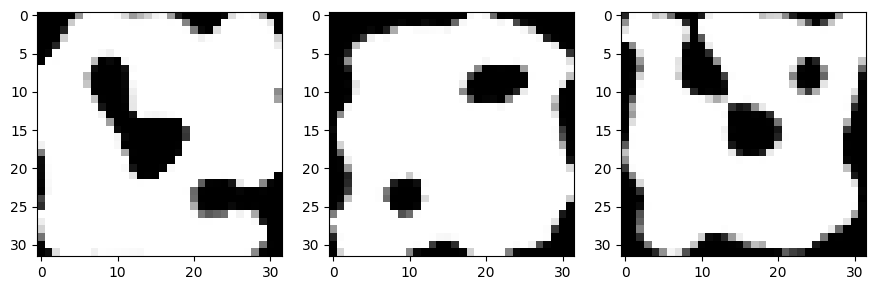

In [8]:
fig = plt.figure(figsize=(9, 3))
for i, idx in enumerate(range(20948, 20948+3)):
    img = imgs_list[idx]
    ax = fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.tight_layout()

##### テストデータの標準偏差の算出

In [7]:
image_ToTensor = transforms.ToTensor()

# テストデータの平均
test_imgs_sum = 0
for img in imgs_list:
    img_t = image_ToTensor(img)
    test_imgs_sum += torch.sum(img_t[0])

test_img_mean = test_imgs_sum / (32*32*len(imgs_list))
print(f'テストデータの平均: {test_img_mean}')

# 訓練データの標準偏差
test_img_L2 = 0
for img in imgs_list:
    img_t = image_ToTensor(img)
    test_img_L2 += torch.sum((img_t[0] - test_img_mean)**2)
test_img_std = torch.sqrt(test_img_L2/(32*32*len(imgs_list)))
print(f'テストデータの標準偏差: {test_img_std}')   

テストデータの平均: 0.6358373761177063
テストデータの標準偏差: 0.3189481198787689


In [8]:
def testTransformer(img):
    img_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.63584), (0.31895))
    ])
    
    img_t = img_transformer(img)

    return img_t

In [9]:
# Testデータ用のDataset
class TestDataset(Dataset):
    '''Test Dataset クラス (サイコロを一つ持つ画像)
    Attributes:
        imgs: testデータの画像のリスト
    '''
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        img_t = testTransformer(img)
    
        return img_t

In [10]:
BATCH_SIZE = 128
test_ds = TestDataset(imgs=imgs_list)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

##### model の読み込み

In [11]:
# model = ResNet18Wrapper()
# model.load_state_dict(torch.load('/mnt/c/Users/user/MyData/SonyDice/models/resnet18_E14.pt'))

model = RegNetWrapper()
# model.load_state_dict(torch.load('/mnt/c/Users/user/MyData/SonyDice/models/regnet32_finetune_L2/E5_2023-10-27_05-06.pt'))
model.load_state_dict(torch.load('/mnt/c/Users/user/MyData/SonyDice/models/regnet32_non_bin_finetune_all_data_from_E8/E6_2023-11-02_22-56.pt'))
model.to(device)

RegNetWrapper(
  (regnet): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(232, 232, kernel_size=

In [12]:
torch.cuda.empty_cache()

In [13]:
pred_label = torch.zeros(len(test_ds), dtype=torch.long)
model.eval()

for iter_num, X in tqdm(enumerate(test_dl), total=len(test_dl)):

    X = X.to(device)

    with torch.no_grad(), torch.autocast('cuda'):
        y_pred, y_softmax = model(X)
        _, label = torch.max(y_softmax, dim=1)
        pred_label[iter_num*BATCH_SIZE: (iter_num+1)*BATCH_SIZE] = label.detach() + 1

100%|██████████| 414/414 [00:26<00:00, 15.64it/s]


In [14]:
pred_label = pred_label.numpy()
pred_label

array([6, 6, 3, ..., 3, 2, 2])

##### 結果の可視化

In [15]:
len(one_dice_idx)

7565

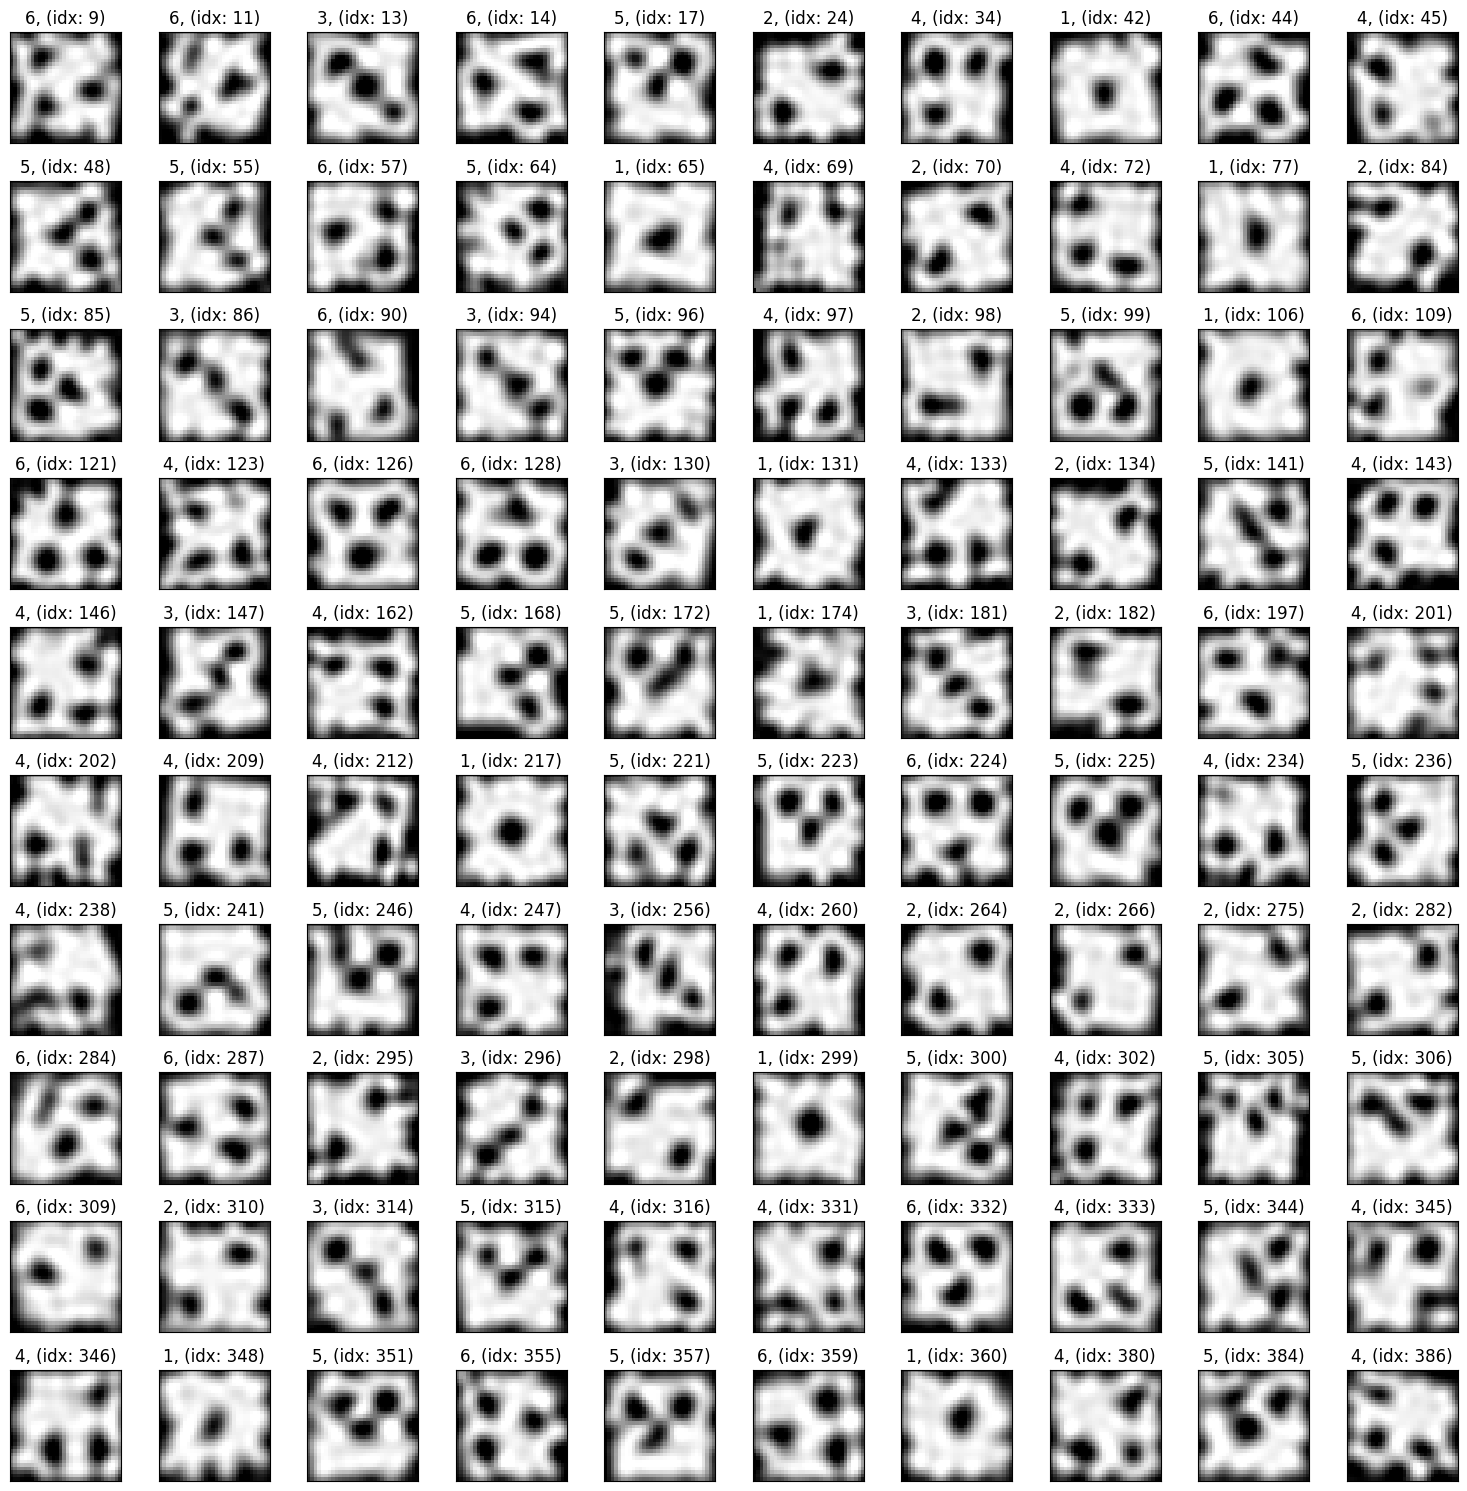

In [15]:
n = 100
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for i in range(n):
    idx = i

    ax = fig.add_subplot(n//10+1, 10, i+1)
    plt.imshow(imgs_list[idx], cmap='gray')
    if idx < len(one_dice_idx):
        org_idx = one_dice_idx[idx]
    elif idx < len(one_dice_idx) + len(two_dice_idx)*2:
        org_idx = two_dice_idx[(idx-len(one_dice_idx))//2]
    else:
        org_idx = three_dice_idx[(idx-len(one_dice_idx)-len(two_dice_idx)*2)//3]

    plt.title(f'{pred_label[idx]}, (idx: {org_idx})')

    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

In [39]:
X_test = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test_renew.npy')
X_test = np.reshape(X_test, (-1, 20, 20))

In [3]:
X_test_denoised = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test_denoised_by_UNet.npy')
X_test_denoised.shape

(24922, 20, 20)

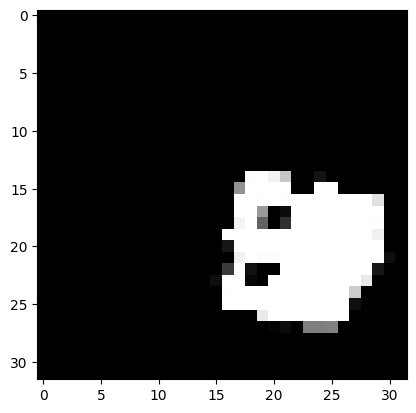

In [19]:
img = X_test_denoised[109, :]
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_LANCZOS4)
plt.imshow(img, cmap='gray')

##### データをまとめる

In [15]:
one_dice_rolls = pred_label[:len(one_dice_idx)]
devided_two_dice_rolls = pred_label[len(one_dice_idx):len(one_dice_idx)+len(two_dice_idx)*2]
devided_three_dice_rolls = pred_label[len(one_dice_idx)+len(two_dice_idx)*2:]

In [16]:
len(one_dice_rolls) + len(devided_two_dice_rolls) / 2 + len(devided_three_dice_rolls) / 3

24922.0

In [17]:
two_dice_rolls = []

for i, roll in enumerate(devided_two_dice_rolls):
    if i % 2 == 0:
        tmp = roll
    else:
        tmp += roll
        two_dice_rolls.append(tmp)

In [18]:
three_dice_rolls = []

for i, roll in enumerate(devided_three_dice_rolls):
    if i % 3 == 0:
        tmp = roll
    else:
        tmp += roll
        if i % 3 == 2:
            three_dice_rolls.append(tmp)

In [19]:
len(two_dice_rolls)

6663

In [20]:
len(three_dice_rolls)

10694

In [21]:
dice_rolls = []
submit_df = pd.read_csv('/mnt/c/Users/user/MyData/SonyDice/sample_submit.csv', header=None)

In [22]:
for i, idx in enumerate(one_dice_idx):
    submit_df.loc[idx, 1] = one_dice_rolls[i]

for i, idx in enumerate(two_dice_idx):
    submit_df.loc[idx, 1] = two_dice_rolls[i]

for i, idx in enumerate(three_dice_idx):
    submit_df.loc[idx, 1] = three_dice_rolls[i]

In [23]:
submit_df

,0,1
0,0,6
1,1,8
2,2,8
3,3,7
4,4,6
...,...,...
24917,24917,11
24918,24918,7
24919,24919,5
24920,24920,11


In [24]:
# submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice_denoised_by_UNet_regnet32_finetune_L2_E5.csv', header=False, index=False)
# submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice_denoised_by_UNet_resnet18_E14.csv', header=False, index=False)
# submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice_denoised_by_UNet_regnet32_finetune_L2_from_E6_E10.csv', header=False, index=False)
# submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice_denoised_by_UNet_regnet32_finetune_E5.csv', header=False, index=False)
# submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice-denoised_by_UNet-regnet32_finetune-E5-modify_manualy_three_dice.csv', header=False, index=False)
# submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice-denoised_by_UNet-regnet32-E8-not_binarization.csv', header=False, index=False)
# submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice-denoised_by_UNet-regnet32-E6-not_binarization.csv', header=False, index=False)
submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice-denoised_by_UNet-regnet32_non_bin_finetune_all_data_from_E8-to_E6.csv', header=False, index=False)

### うまく分離できてないサイコロやノイズを修正する

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering

from dsets import  getOneDiceRectanglar

In [54]:
X_test_denoised = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test_denoised_by_UNet.npy')
X_test_denoised.shape

(24922, 20, 20)

In [55]:
# 90 < w, h < 140 の仕切りでサイコロがないもしくは2個以上あると判定されたもの
not_one_dice_idx = [40, 4173, 5042, 5165, 7105, 7632, 8036, 10823, 11393, 12440, 13446, 14736, 16695, 17129, 18346, 23299]

# あきらめ: 5042, 8036, 17129, 

In [ ]:
# 面積が大きい画像
big_imgs_idx = [1912, 15731, 16116, 10424, 12704, 5221, 1947, 3465, 8643, 16524, 17290, 20683, 22024, 24251, 18316] 
# あきらめ: 21328, 16524

In [466]:
def devideThreeImage(idx, data_type, rs=1, assign_labels='discretize', affin='nearest_neighbors'):
    '''3つのサイコロを持つ画像を3つの画像に分離し, 画像をリストとして返す関数
    Return:
        imgs_list: デノイズ処理された分離された画像(ndarray)のリスト, 長さは元の3倍, (20*20)'''
    
    assert data_type in ['test', 'test_denoised'], 'この関数はテストデータしか受け付けません'

    imgs_list = []

    if data_type == 'test':
        X = X_test
    elif data_type == 'test_denoised':
        X = X_test_denoised

    for i in idx:
        img = X[i, :]

        # デノイズ
        if data_type == 'test':
            img = cv2.fastNlMeansDenoising(src=img, h=30, templateWindowSize=3, searchWindowSize=7)

        dice_pix = []
        for j in range(20):
            for k in range(20):
                if img[j, k] >= 50:
                    dice_pix.append([j, k])
        dice_pix = np.array(dice_pix)
        
        # spectral clustering
        clustering = SpectralClustering(n_clusters=3, 
                                        assign_labels=assign_labels, 
                                        random_state=rs, 
                                        affinity=affin).fit(dice_pix)
        
        # 一つ目の画像
        img_copy = img.copy()
        for l, [x, y] in enumerate(dice_pix):
            label = clustering.labels_[l]
            if label == 0 or label == 1:
                img_copy[x, y] = 1
        imgs_list.append(img_copy)

        # 二つ目の画像
        img_copy = img.copy()
        for m, [x, y] in enumerate(dice_pix):
            label = clustering.labels_[m]
            if label == 1 or label == 2:
                img_copy[x, y] = 1
        imgs_list.append(img_copy)

        # 三つ目の画像
        img_copy = img.copy()
        for n, [x, y] in enumerate(dice_pix):
            label = clustering.labels_[n]
            if label == 2 or label == 0:
                img_copy[x, y] = 1
        imgs_list.append(img_copy)

    return imgs_list

##### ひとつずつrandom_stateを変えながら

In [489]:
this_img_idx = 18316

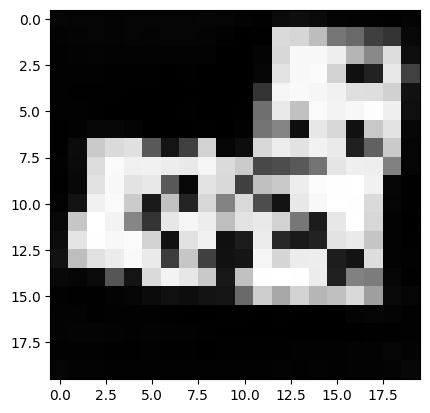

In [490]:
plt.imshow(X_test_denoised[this_img_idx, :], cmap='gray')

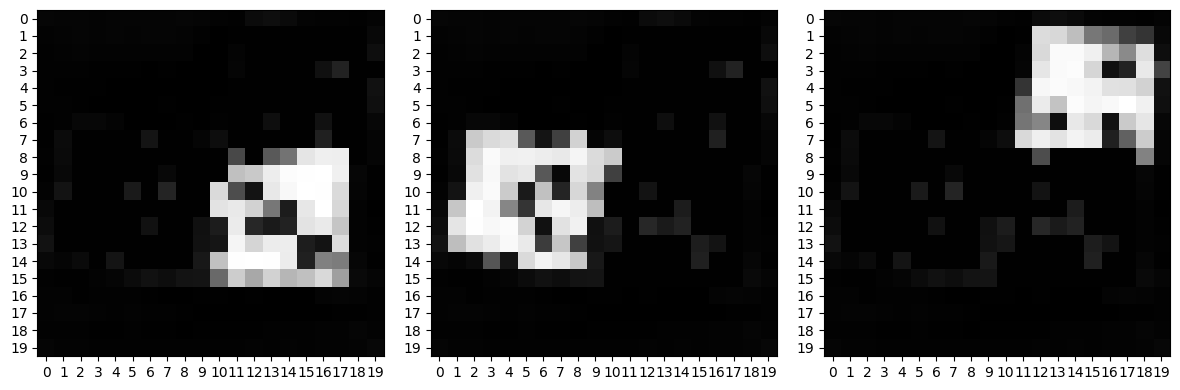

In [491]:
# spectral clurstering
imgs_list_three = devideThreeImage(idx=[this_img_idx], data_type='test_denoised', rs=5, assign_labels='discretize', affin='nearest_neighbors')
# imgs_list_three = devideThreeImage(idx=this_idx, data_type='test_denoised', rs=10, assign_labels='kmeans')
# imgs_list_three = devideThreeImage(idx=this_idx, data_type='test_denoised', rs=2, assign_labels='cluster_qr')

img_tmp_list = []

fig = plt.figure(figsize=(12, 4))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    img = imgs_list_three[i]
    img_tmp_list.append(img)
    # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    # thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    plt.imshow(img, cmap='gray')
    plt.xticks(list(range(20)))
    plt.yticks(list(range(20)))
    plt.tight_layout() 

In [492]:
# # 任意
img_tmp_list[2][8, 12:19] = int(225)
# img_tmp_list[1][8, 12:19] = int(1)

In [493]:
imgs_output = np.zeros((3, 32, 32), dtype=np.uint8)

for i, img in enumerate(img_tmp_list):
    center, size, angle, _, _ = getOneDiceRectanglar(img, 'test_denoised')
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # resize, binarization
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    width, height = img.shape

    # 変換行列
    trans = cv2.getRotationMatrix2D(center, angle, scale=1)
    
    # Rotation
    img = cv2.warpAffine(img, trans, (width, height))

    # Crop
    img = cv2.getRectSubPix(img, size, center)

    # resize lanczos
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_LANCZOS4)

    imgs_output[i, :] = img.astype(np.uint8)

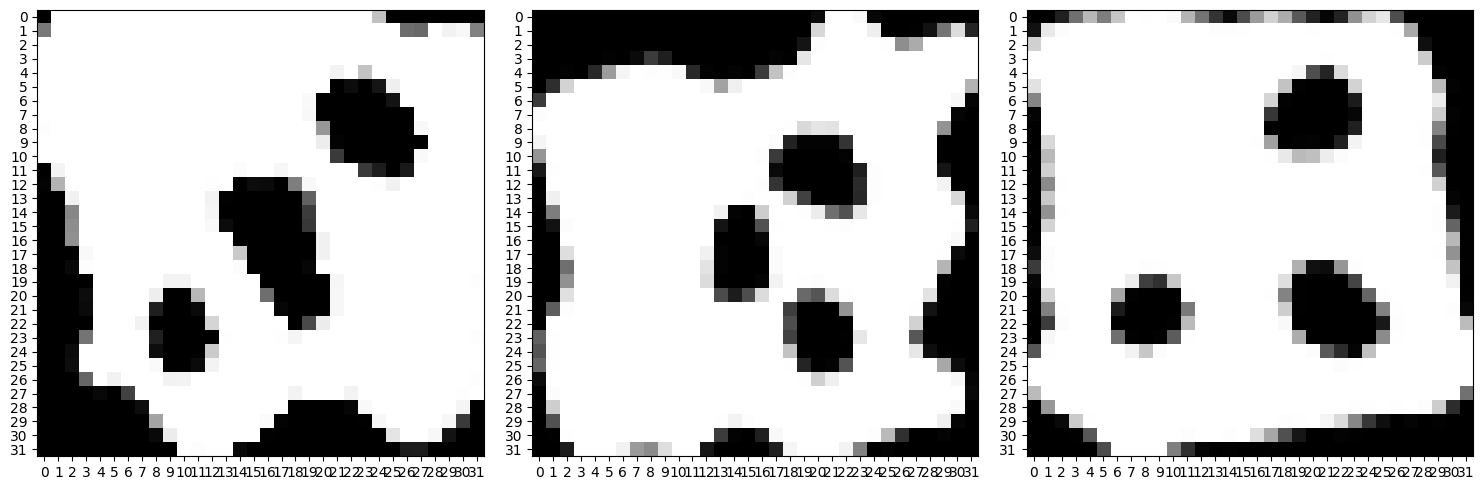

In [494]:
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    img = imgs_output[i, :]
    # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    # thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    plt.imshow(img, cmap='gray')
    plt.xticks(list(range(32)))
    plt.yticks(list(range(32)))
    plt.tight_layout() 

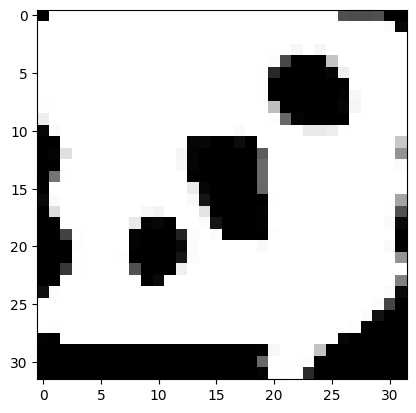

In [482]:
# 修正(ここは必要があれば)
modified_img = imgs_output[2, :].copy()
modified_img[24: 29, 2: 26] = int(255)
plt.imshow(modified_img, cmap='gray')

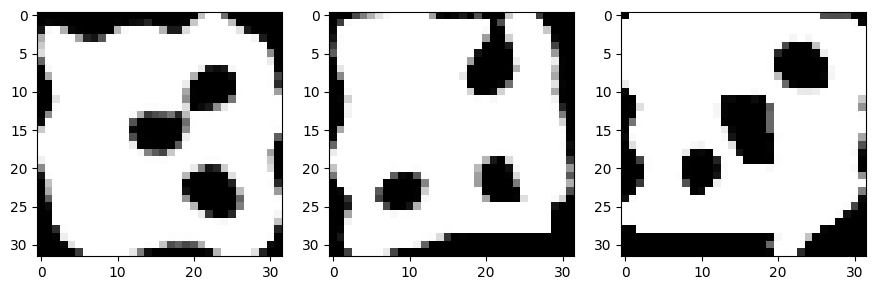

In [483]:
imgs_output[2, :] = modified_img
fig = plt.figure(figsize=(9, 3))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    img = imgs_output[i, :]
    # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    # thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    plt.imshow(img, cmap='gray')
    plt.tight_layout() 

In [495]:
np.save(f'/mnt/c/Users/user/MyData/SonyDice/imgs_modified/{this_img_idx}.npy', imgs_output)